In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
main_dir = 'D:/NLP Project/Arabic-Dialect-Identification-using-LLAMA-3/data/'
train_cleaned = pd.read_csv(main_dir + "train_cleaned.csv")
test_cleaned = pd.read_csv(main_dir + "test_cleaned.csv")

---

In [5]:
map_dict = {
    "United Arab Emirates":0,
    "Bahrain":1,
    "Algeria":2,
    "Egypt":3,
    "Iraq":4,
    "Jordan":5,
    "Kuwait":6,
    "Lebanon":7,
    "Libya":8,
    "Morocco":9,
    "Oman":10,
    "Palestine":11,
    "Qatar":12,
    "Saudi Arabia":13,
    "Sudan":14,
    "Syria":15,
    "Tunisia":16,
    "Yemen":17,
}
dict_label_map = { v: k for k, v in map_dict.items() }
num_labels = len(map_dict)

idx_mapper = lambda x: map_dict[x]
train_cleaned['label'] = train_cleaned['label'].apply(idx_mapper)

# Filter the DataFrame and then apply the mapping function
test_filtered = test_cleaned[test_cleaned['label'] != "Modern Standard Arabic"].copy()
test_filtered['label'] = test_filtered['label'].apply(idx_mapper)

# Assign the mapped values back to the original DataFrame
test_cleaned.loc[test_cleaned['label'] != "Modern Standard Arabic", 'label'] = test_filtered['label']
test_cleaned = test_cleaned[test_cleaned.label != 'Modern Standard Arabic']

---

In [6]:
# Splitting data into features and labels
x_train = train_cleaned["text_cleaned"]
y_train = np.array(train_cleaned["label"]).astype(int)

x_test = test_cleaned["text_cleaned"]
y_test = np.array(test_cleaned["label"]).astype(int)

In [7]:
nb_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10]
}

rf_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20]
}

dt_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__max_depth': [None, 10, 20]
}

knn_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_neighbors': [3,4,5,6,7]
}

xgb_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [50, 100, 150]
}

svm_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

In [8]:
def run_grid_search(model, param_grid, model_name, x_train, y_train, x_test):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    train_accuracy = grid_search.best_estimator_.score(x_train, y_train)
    test_accuracy = grid_search.best_estimator_.score(x_test, y_test)

    print("Train accuracy for {}:".format(model_name), train_accuracy)
    print("Test accuracy for {}:".format(model_name), test_accuracy)
    print("Best parameters for {}: {}".format(model_name, grid_search.best_params_))

    # Predict on test data
    y_pred = grid_search.best_estimator_.predict(x_test)

    return train_accuracy, test_accuracy, y_pred

# Lists to store train and test accuracies for each algorithm
train_accuracies = []
test_accuracies = []

In [9]:
nb_train_accuracy, nb_test_accuracy, nb_y_pred = run_grid_search(MultinomialNB(), nb_param_grid, "Naive Bayes", x_train, y_train, x_test)
train_accuracies.append(nb_train_accuracy)
test_accuracies.append(nb_test_accuracy)
print("Predicted labels for Naive Bayes:", nb_y_pred)

Train accuracy for Naive Bayes: 0.9973944444444445
Test accuracy for Naive Bayes: 0.6688907422852377
Best parameters for Naive Bayes: {'clf__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Predicted labels for Naive Bayes: [ 3  3 11 ...  9  9  9]


In [14]:
macro_f1 = f1_score(y_test, nb_y_pred, average='macro')
print("Macro F1 score:", macro_f1)

Macro F1 score: 0.6675545410535375


In [10]:
map_dict = {
    0:"UAE",
    1:"BH",
    2:"ALGR",
    3:"EG",
    4:"IQ",
    5:"JORD",
    6:"KW",
    7:"LEBN",
    8:"LBYA",
    9:"MAR",
    10:"OM",
    11:"PS",
    12:"QA",
    13:"SA",
    14:"SD",
    15:"SY",
    16:"Tunisia",
    17:"YE",
}

nb_y_pred_after = [map_dict[label] for label in nb_y_pred]
y_test_after = [map_dict[label] for label in y_test]

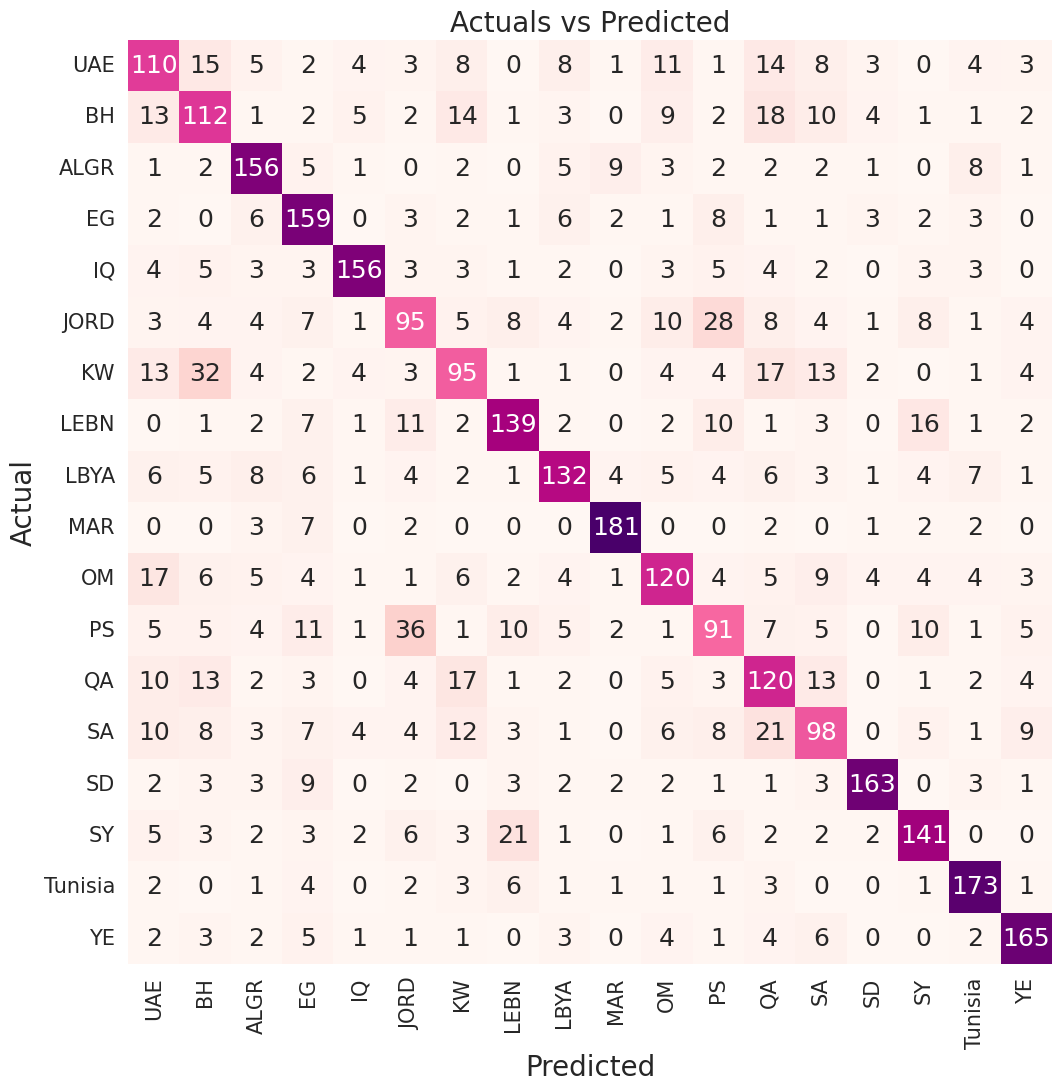

In [21]:
data = confusion_matrix(y_test_after, nb_y_pred_after,labels=list(map_dict.values()))
df_cm = pd.DataFrame(data, columns=list(map_dict.values()), index=list(map_dict.values()) )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


cmap = 'RdPu'
f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 18})

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.title('Actuals vs Predicted', fontsize=20)
plt.show()